In [288]:
import torch
import torch.nn as nn

# Copy from Fashion-MNIST/code/model.py
class BlackBoxCNN(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.layers = nn.Sequential(
                nn.Conv2d(1, 24, 5, 1, 2),
                nn.ReLU(),
                nn.Conv2d(24, 48, 5, 2, 2),
                nn.ReLU(),
                nn.Conv2d(48, 64, 5, 3, 2),
                nn.ReLU(),
                nn.Flatten(),
                nn.Linear(5 * 5 * 64, 200),
                nn.ReLU(),
                nn.Linear(200, 10)
            )

    def forward(self, x):
        
        x = x.reshape((-1, 1, 28, 28))
        return self.layers(x)
    
attacked_model = BlackBoxCNN()
attacked_model.load_state_dict(torch.load('../model/cnn.ckpt'))

attacked_model

BlackBoxCNN(
  (layers): Sequential(
    (0): Conv2d(1, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(24, 48, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(48, 64, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1600, out_features=200, bias=True)
    (8): ReLU()
    (9): Linear(in_features=200, out_features=10, bias=True)
  )
)

In [289]:
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset

with open('../attack_data/correct_1k.pkl', 'rb') as f:
    data = pickle.load(f)

images = torch.tensor(np.array(data[0]))
labels = torch.tensor(np.array(data[1]))

print("Loaded images shape:", images.shape)
print("Loaded labels shape:", labels.shape)


class CorrectDataset(Dataset):
    def __init__(self, images, labels):
        super().__init__()
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, index):
        return self.images[index], self.labels[index]
    
correct_dataset = CorrectDataset(images, labels)
correct_dataset_loader = DataLoader(correct_dataset, batch_size=64, shuffle=True)

print("Correct dataset size:", len(correct_dataset))

Loaded images shape: torch.Size([1000, 784])
Loaded labels shape: torch.Size([1000])
Correct dataset size: 1000


In [290]:
import torch
import numpy as np
import torch.nn.functional as F

def mcmc_blackbox_attack(model, correct_dataset_loader, target_mapping, device, sigma=100, delta_max=2000.0, max_iter=100):
    adversarial_samples = []
    
    model.to(device)
    model.eval()
    
    for images, labels in correct_dataset_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        target_labels = torch.tensor([target_mapping[label.item()] for label in labels], device=device)
        
        current_samples = images.clone()
        
        for i in range(len(images)):
            for _ in range(max_iter):
                noise = torch.randn_like(current_samples[i]) * sigma
                candidate = current_samples[i] + noise
                candidate = torch.clamp(candidate, 0, 255)  
                
                # 计算单步扰动的变化阈值
                dist = torch.norm(candidate - current_samples[i], p=2)
                
                if dist > delta_max:
                    continue  # 距离过大，拒绝样本
            
                # 预测候选样本的类别概率
                with torch.no_grad():
                    output = model(candidate.unsqueeze(0)) # 添加 batch 维度 1
                    probabilities = F.softmax(output, dim=1).squeeze(0) # probabilities (10,)
                    target_prob = probabilities[target_labels[i]] # target_prob (1,)
            
                # 接受或拒绝候选样本
                if torch.rand(1) <= target_prob.item():
                    current_samples[i] = candidate
                    if probabilities.argmax(0) == target_labels[i]:
                        adversarial_samples.append((images[i],current_samples[i], labels[i], target_labels[i]))
                        break  # 已成功生成对抗样本

        print("Current adversarial samples count:", len(adversarial_samples))
    
    return adversarial_samples


In [296]:
target_mapping = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 0}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 调用攻击函数
adversarial_samples = mcmc_blackbox_attack(attacked_model, correct_dataset_loader, target_mapping, device,\
                                           sigma = 40, delta_max= 900, max_iter=1000)


print("Number of adversarial samples:", len(adversarial_samples))
print(f"Success black-box attack rate: {len(adversarial_samples) / len(correct_dataset) * 100:.2f}%")

Current adversarial samples count: 10
Current adversarial samples count: 18
Current adversarial samples count: 26
Current adversarial samples count: 37
Current adversarial samples count: 44
Current adversarial samples count: 54
Current adversarial samples count: 66
Current adversarial samples count: 77
Current adversarial samples count: 91
Current adversarial samples count: 104
Current adversarial samples count: 114
Current adversarial samples count: 129
Current adversarial samples count: 142
Current adversarial samples count: 151
Current adversarial samples count: 163
Current adversarial samples count: 170
Number of adversarial samples: 170
Success black-box attack rate: 17.00%


In [ ]:
import random

for ori_img, adv_img, orig_label, adv_label in random.sample(adversarial_samples, 10):
    print(f"Original label: {orig_label}, Adversarial label: {adv_label}")

Original label: 7, Adversarial label: 8
Original label: 7, Adversarial label: 8
Original label: 2, Adversarial label: 3
Original label: 5, Adversarial label: 6
Original label: 2, Adversarial label: 3
Original label: 0, Adversarial label: 1
Original label: 7, Adversarial label: 8
Original label: 3, Adversarial label: 4
Original label: 5, Adversarial label: 6
Original label: 5, Adversarial label: 6


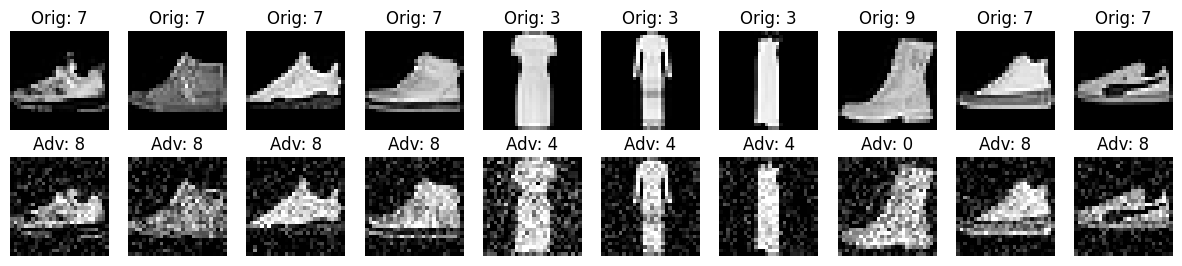

In [306]:
selected_samples = random.sample(adversarial_samples, 10)

import matplotlib.pyplot as plt

# 显示图像和分类结果
fig, axs = plt.subplots(2, 10, figsize=(15, 3))

for i, (ori_img, adv_img, ori_label, adv_label) in enumerate(selected_samples):
    # 展示原始图像
    axs[0, i].imshow(ori_img.cpu().reshape(28,28), cmap='gray') 
    axs[0, i].title.set_text(f"Orig: {ori_label}")
    axs[0, i].axis('off')

    # 展示对抗样本图像
    axs[1, i].imshow(adv_img.cpu().reshape(28, 28), cmap='gray') 
    axs[1, i].title.set_text(f"Adv: {adv_label}")
    axs[1, i].axis('off')

plt.show()